In [857]:
# overhead

import logging
import math
import random
import numpy as np
import time
import torch as t
import torch.nn as nn
from torch import optim
from torch.nn import utils
import matplotlib.pyplot as plt
import matplotlib.animation as animation

logger = logging.getLogger(__name__)

In [858]:
# environment parameters

FRAME_TIME = 0.1  # time interval
GRAVITY_ACCEL = 0.12  # gravity constant
BOOST_ACCEL = 0.18  # thrust constant

# # the following parameters are not being used in the sample code
PLATFORM_WIDTH = 0.25  # landing platform width
PLATFORM_HEIGHT = 0.  # landing platform height
w1 = [-PLATFORM_WIDTH, PLATFORM_WIDTH]
w2 = [0.1*-PLATFORM_WIDTH, 0.1*PLATFORM_WIDTH]
h = [PLATFORM_HEIGHT, PLATFORM_HEIGHT]
ROTATION_ACCEL = np.radians(20)  # rotation constant

In [859]:
# define system dynamics
# Notes:
# 0. You only need to modify the "forward" function
# 1. All variables in "forward" need to be PyTorch tensors.
# 2. All math operations in "forward" has to be differentiable, e.g., default PyTorch functions.
# 3. Do not use inplace operations, e.g., x += 1. Please see the following section for an example that does not work.

class Dynamics(nn.Module):

    def __init__(self):
        super(Dynamics, self).__init__()

    @staticmethod
    def forward(state, action):

        """
        action: thrust or no thrust
        state[0] = y
        state[1] = y_dot
        """

        delta_state_ori = ROTATION_ACCEL* FRAME_TIME*t.tensor([0., 1, 0., 0., 0., 0.])

        sin = t.matmul(t.tensor([[0., 0., 0., 0., 0., 0.],
                                 [0., 0., 0., 0., 0., 0.],
                                 [0., 0., 0., 0., 0., 0.],
                                 [-1., 0., 0., 0., 0., 0.],
                                 [0., 0., 0., 0., 0., 0.],
                                 [0., 0., 0., 0., 0., 0.]]),t.sin(t.transpose(state,0,1)))
        cos = t.matmul(t.tensor([[0., 0., 0., 0., 0., 0.],
                                 [0., 0., 0., 0., 0., 0.],
                                 [0., 0., 0., 0., 0., 0.],
                                 [0., 0., 0., 0., 0., 0.],
                                 [0., 0., 0., 0., 0., 0.],
                                 [1., 0., 0., 0., 0., 0.]]),t.cos(t.transpose(state,0,1)))
        cos_sin = cos+sin
        cos_sin = t.transpose(cos_sin,0,1)
        delta_state_pos = BOOST_ACCEL* FRAME_TIME*t.tensor([0., 0., 0., 1., 0., 1.])*cos_sin # x and y components of acceleration

        delta_state_combine = delta_state_ori + delta_state_pos

        action_mat = t.tensor([[0., 0.],
                         [2., 0.],
                         [0., 0.],
                         [0., 1.],
                         [0., 0.],
                         [0., 1.]])

        a_a = t.add(t.transpose(t.matmul(action_mat, t.transpose(action,0,1)),0,1) , t.tensor([0., -1., 0., 0., 0., 0.]))# get ori and pos accelerations

        delta_state = delta_state_combine*a_a

        state_gravity = GRAVITY_ACCEL * FRAME_TIME*t.tensor([0., 0., 0., 0., 0., -1.])
        state = state + delta_state + state_gravity

        step_mat = t.tensor([[1., FRAME_TIME, 0., 0., 0., 0.],
                             [0., 1., 0., 0., 0., 0.],
                             [0., 0., 1., FRAME_TIME, 0., 0.],
                             [0., 0., 0., 1., 0., 0.],
                             [0., 0., 0., 0., 1., FRAME_TIME,],
                             [0., 0., 0., 0., 0., 1.]])
        state = t.transpose(t.matmul(step_mat, t.transpose(state,0,1)),0,1)

        return state

In [860]:
# a deterministic controller
# Note:
# 0. You only need to change the network architecture in "__init__"
# 1. nn.Sigmoid outputs values from 0 to 1, nn.Tanh from -1 to 1
# 2. You have all the freedom to make the network wider (by increasing "dim_hidden") or deeper (by adding more lines to nn.Sequential)
# 3. Always start with something simple

class Controller(nn.Module):

    def __init__(self, dim_input, dim_hidden1, dim_hidden2, dim_output):
        """
        dim_input: # of system states
        dim_output: # of actions
        dim_hidden: up to you
        """
        super(Controller, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(dim_input, dim_hidden1),
            nn.Tanh(),
            nn.Linear(dim_hidden1, dim_hidden2),
            nn.Tanh(),
            nn.Linear(dim_hidden2, dim_output),
            nn.Sigmoid()
        )

    def forward(self, state):
        action = self.network(state)
        return action

In [861]:
# the simulator that rolls out x(1), x(2), ..., x(T)
# Note:
# 0. Need to change "initialize_state" to optimize the controller over a distribution of initial states
# 1. self.action_trajectory and self.state_trajectory stores the action and state trajectories along time

class Simulation(nn.Module):

    def __init__(self, controller, dynamics, T, N):
        super(Simulation, self).__init__()
        self.state = self.initialize_state(N)
        self.controller = controller
        self.dynamics = dynamics
        self.T = T
        self.action_trajectory = []
        self.state_trajectory = []

    def forward(self, state):
        self.action_trajectory = []
        self.state_trajectory = []
        for _ in range(T):
            action = self.controller.forward(state)
            state = self.dynamics.forward(state, action)
            self.action_trajectory.append(action)
            self.state_trajectory.append(state)
        return self.error(state)

    @staticmethod
    def initialize_state(n):
        initial = np.zeros((n,6))
        for i in range(n):
            initial[i] = [0.5*math.pi*(random.random()-0.5), 0.1*math.pi*(random.random()-0.5), # orientation state
                     (random.random()-0.5), 0.1*(random.random()-0.5), # horizontal state
                     0.5*random.random()+1, -0.1*random.random()]  # vertical state
        print(initial)
        return t.tensor(initial, requires_grad=False).float()
    def error(self, state):
        states = t.square(state).sum(dim=0)*t.tensor([1., 1., 0.01, 1., 1., 0.5]) # weight of each state
        return states.sum(dim=0)

In [862]:
# set up the optimizer
# Note:
# 0. LBFGS is a good choice if you don't have a large batch size (i.e., a lot of initial states to consider simultaneously)
# 1. You can also try SGD and other momentum-based methods implemented in PyTorch
# 2. You will need to customize "visualize"
# 3. loss.backward is where the gradient is calculated (d_loss/d_variables)
# 4. self.optimizer.step(closure) is where gradient descent is done

class Optimize:
    def __init__(self, simulation):
        self.simulation = simulation
        self.parameters = simulation.controller.parameters()
        self.optimizer = optim.LBFGS(self.parameters, lr=0.01)

    def step(self):
        def closure():
            loss = self.simulation(self.simulation.state)
            self.optimizer.zero_grad()
            loss.backward()
            return loss
        self.optimizer.step(closure)
        return closure()

    def train(self, eps, max_epoch):
        conv_log = []
        conv_itr = []
        epoch = 0
        error = 100
        while error > eps and epoch <= max_epoch:
            loss = self.step()
            conv_log.append(loss.item())
            conv_itr.append(epoch)
            epoch += 1
            print('[%d] loss: %.3f' % (epoch, loss))
            error = loss.item()
            cord = self.visualize()
        print('Landing Trajectory:')
        for r in range(N):
            plt.quiver(cord[:,r, 2], cord[:,r, 4], -0.05*np.sin(cord[:,r, 0]), 0.05*np.cos(cord[:,r, 0]))
            plt.quiver(cord[-1,r, 2], cord[-1,r, 4], -0.05*np.sin(cord[-1,r, 0]), 0.05*np.cos(cord[-1,r, 0]),color='orange')
            plt.plot(w1, h, color="red", linewidth=3)
            plt.plot(w2, h, color="green", linewidth=3)
            plt.show()
        print('Convergence Plot:')
        plt.plot(conv_itr, conv_log)
        plt.yscale("log")
        plt.show()

    def visualize(self):
        data = np.array([self.simulation.state_trajectory[i].detach().numpy() for i in range(self.simulation.T)])
        plt.scatter(data[:,0,2], data[:,0,4],s=5)
        plt.plot(w1, h, color="red", linewidth=3)
        plt.plot(w2, h, color="green", linewidth=3)
        plt.show()
        return data

[[-2.22446238e-02  1.08068499e-01 -4.22663584e-01  2.70186534e-02
   1.27810986e+00 -7.91359342e-02]
 [-6.82625321e-02 -1.00632456e-01  2.72995367e-01  1.42362887e-02
   1.33540298e+00 -1.13308484e-03]
 [-5.11430094e-01  2.13368038e-02 -4.63083757e-01  2.69054751e-02
   1.20131990e+00 -8.68730257e-02]
 [ 3.85259026e-01 -1.32450049e-01  9.81756781e-02  4.36729326e-05
   1.09141941e+00 -4.10895363e-02]
 [ 1.74954478e-02  8.01734596e-02 -1.00298716e-01 -3.05091997e-02
   1.43982377e+00 -7.98196952e-02]
 [ 1.13365199e-01 -4.42337884e-02 -3.80274312e-02 -3.99191386e-02
   1.44209292e+00 -4.01235042e-02]
 [ 5.09093775e-01  1.20840297e-01  4.26594996e-01 -7.39499570e-03
   1.11014343e+00 -8.64009309e-02]
 [-3.14936850e-01 -2.32504267e-03 -2.81705322e-01  4.40305857e-02
   1.28061874e+00 -9.89679335e-02]
 [-7.53631258e-01 -1.50432483e-01 -3.36266649e-01 -6.00246216e-03
   1.06392114e+00 -7.01616818e-02]
 [-2.91460074e-01  1.52453695e-01 -2.33303010e-01  4.96006877e-03
   1.47168459e+00 -4.2417

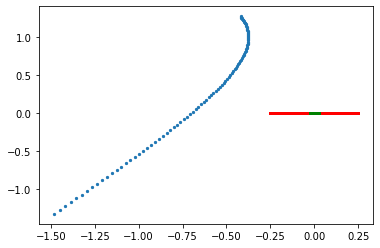

[2] loss: 30.482


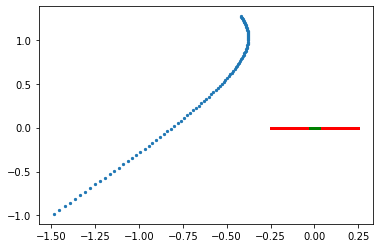

[3] loss: 20.772


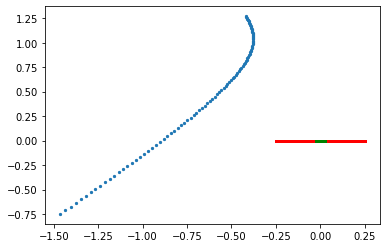

[4] loss: 15.418


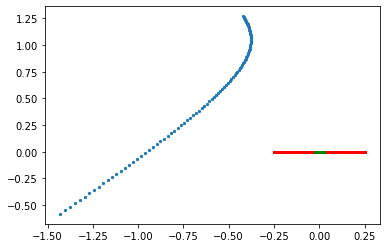

[5] loss: 12.142


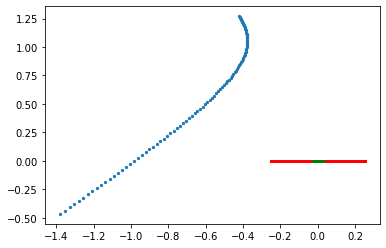

[6] loss: 9.508


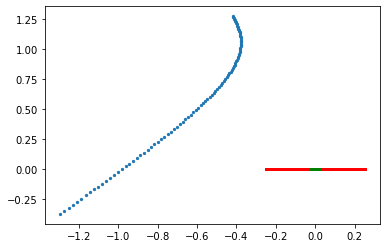

[7] loss: 6.556


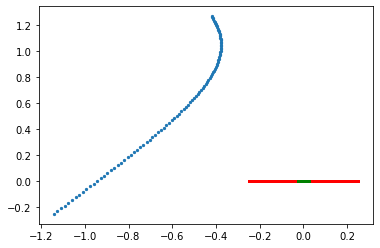

[8] loss: 3.631


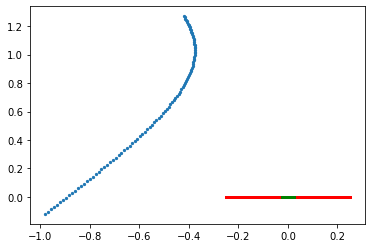

[9] loss: 2.335


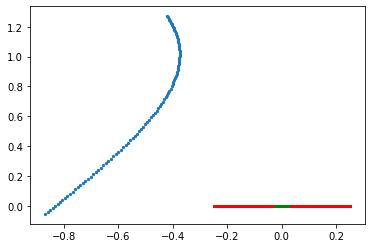

[10] loss: 1.533


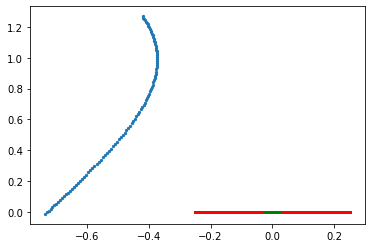

[11] loss: 1.067


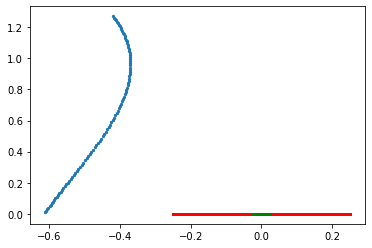

[12] loss: 0.810


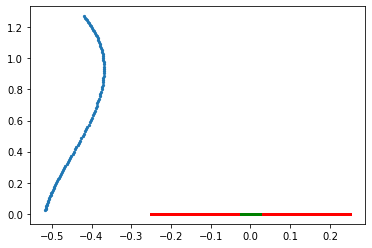

[13] loss: 0.635


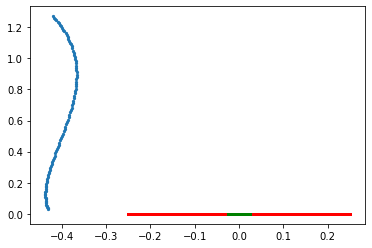

[14] loss: 0.504


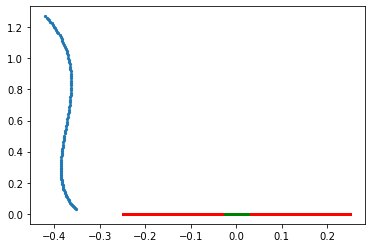

[15] loss: 0.403


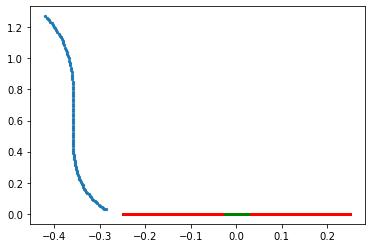

[16] loss: 0.321


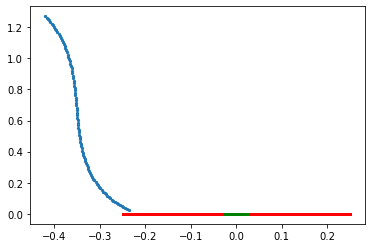

[17] loss: 0.254


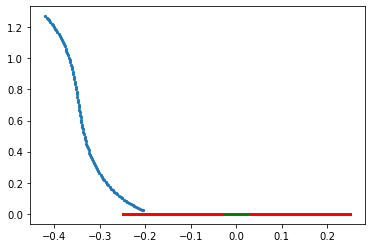

[18] loss: 0.198


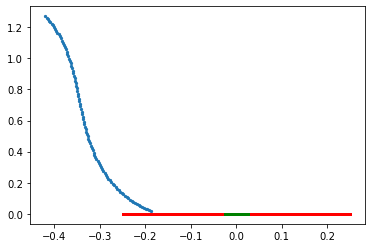

[19] loss: 0.154


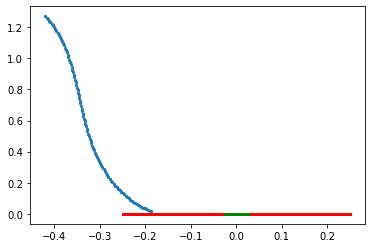

[20] loss: 0.121


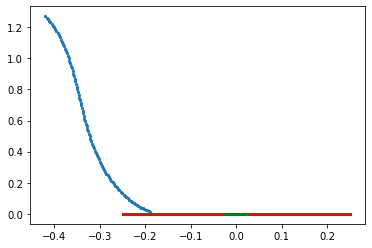

[21] loss: 0.096


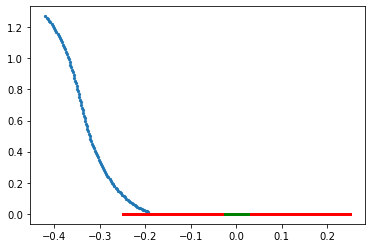

[22] loss: 0.077


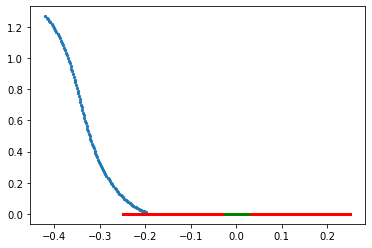

[23] loss: 0.063


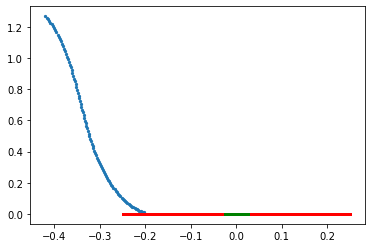

[24] loss: 0.052


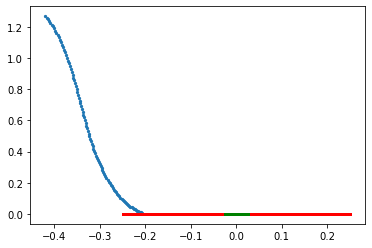

[25] loss: 0.043


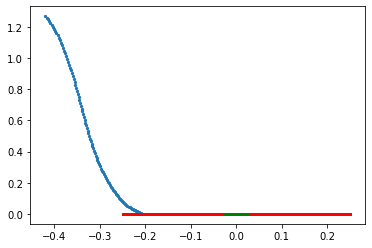

[26] loss: 0.037


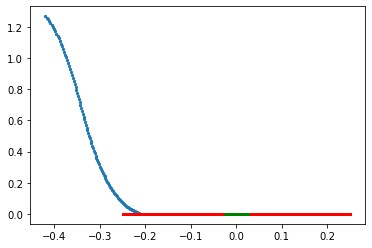

[27] loss: 0.031


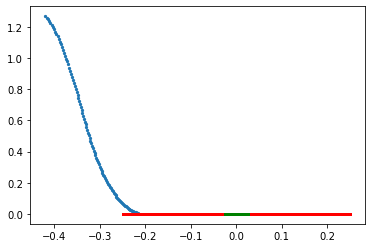

[28] loss: 0.027


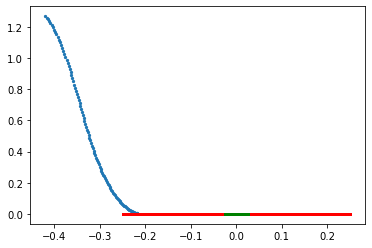

[29] loss: 0.024


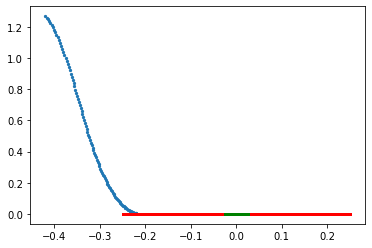

[30] loss: 0.021


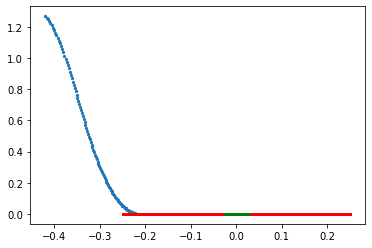

[31] loss: 0.019


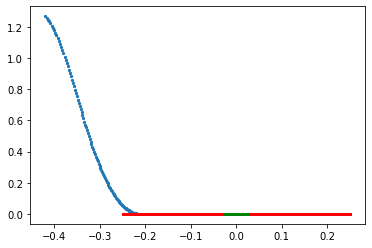

[32] loss: 0.017


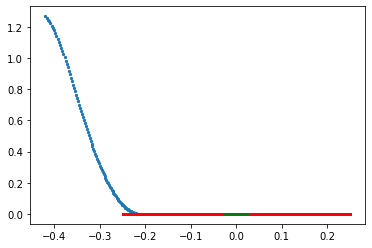

[33] loss: 0.015


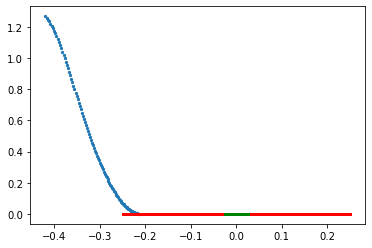

[34] loss: 0.013


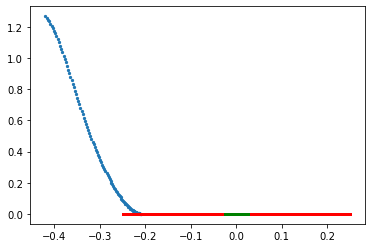

[35] loss: 0.012


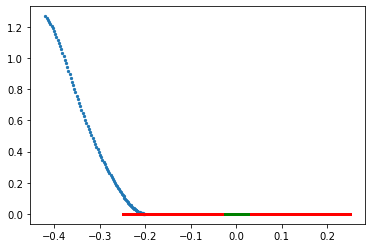

[36] loss: 0.008


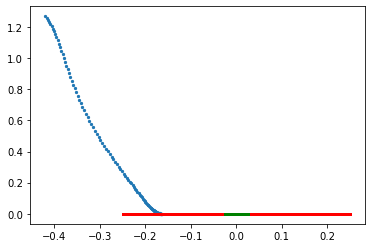

[37] loss: 0.005


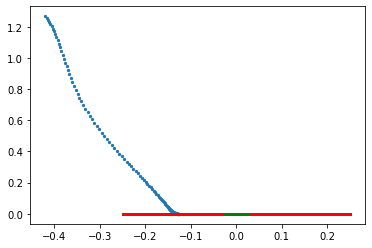

[38] loss: 0.004


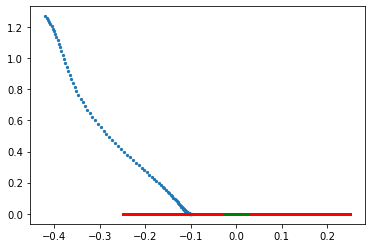

[39] loss: 0.003


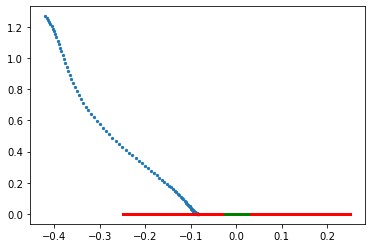

[40] loss: 0.003


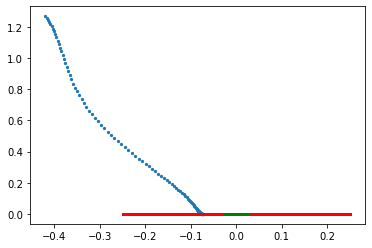

[41] loss: 0.002


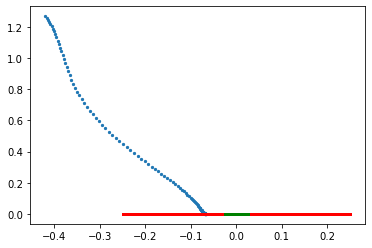

[42] loss: 0.002


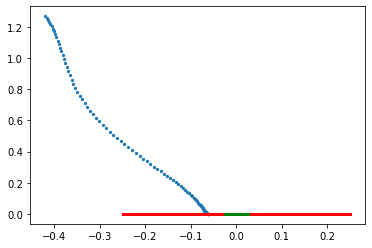

[43] loss: 0.002


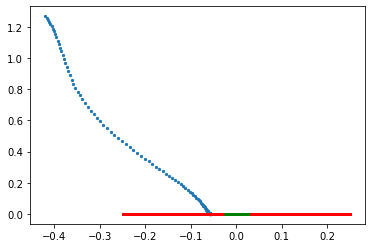

[44] loss: 0.002


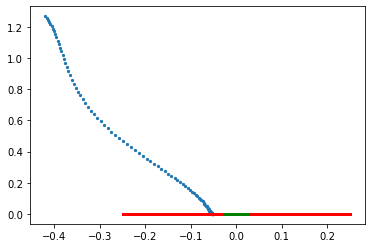

[45] loss: 0.001


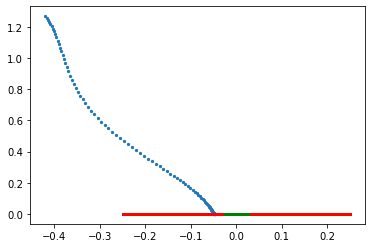

[46] loss: 0.001


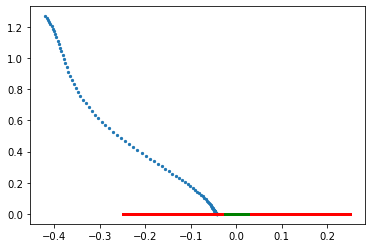

[47] loss: 0.001


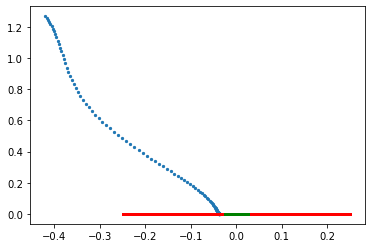

[48] loss: 0.001


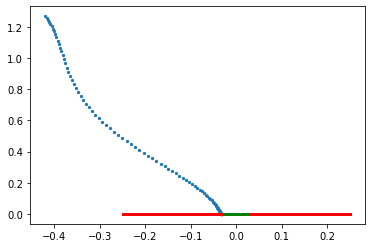

[49] loss: 0.001


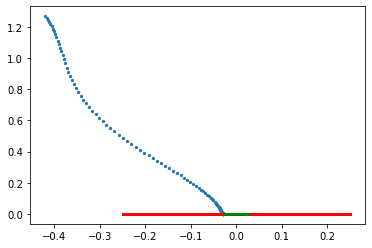

[50] loss: 0.001


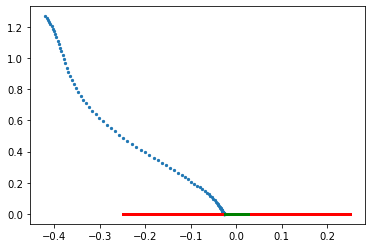

[51] loss: 0.001


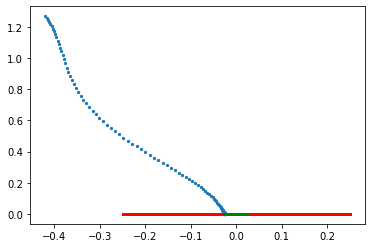

[52] loss: 0.000


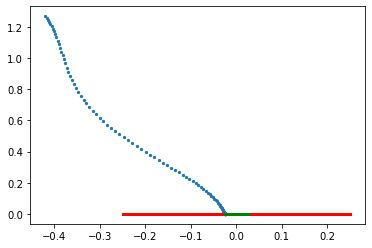

[53] loss: 0.000


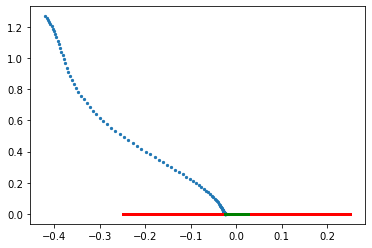

[54] loss: 0.000


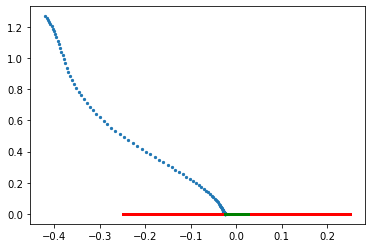

[55] loss: 0.000


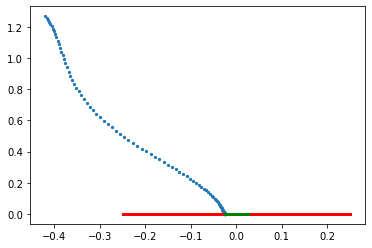

[56] loss: 0.000


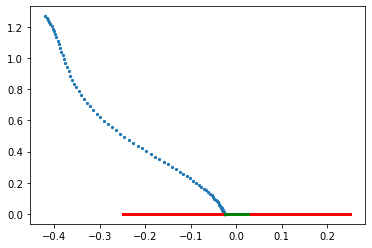

[57] loss: 0.000


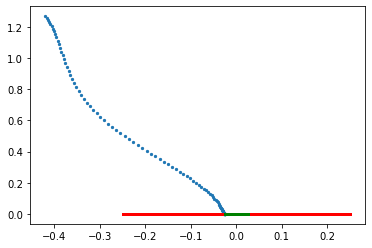

[58] loss: 0.000


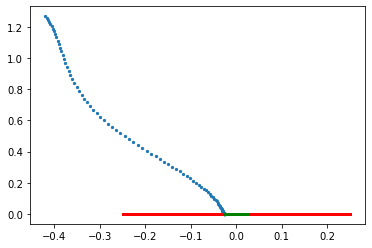

[59] loss: 0.000


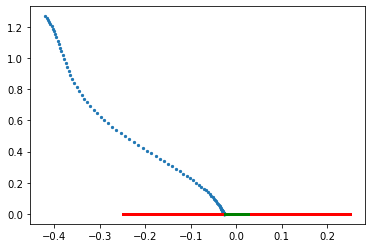

[60] loss: 0.000


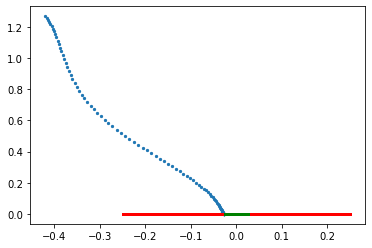

[61] loss: 0.000


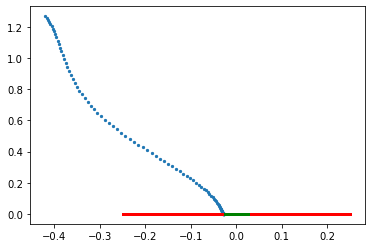

[62] loss: 0.000


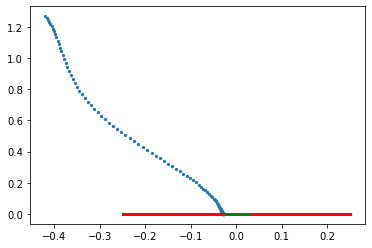

[63] loss: 0.000


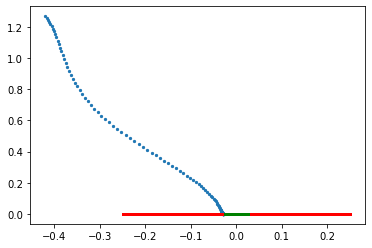

[64] loss: 0.000


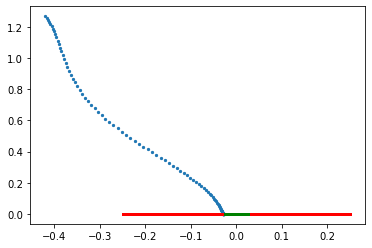

[65] loss: 0.000


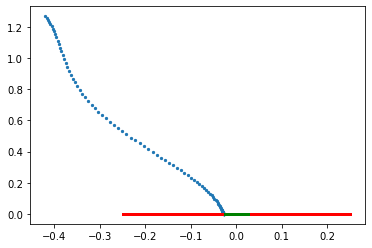

[66] loss: 0.000


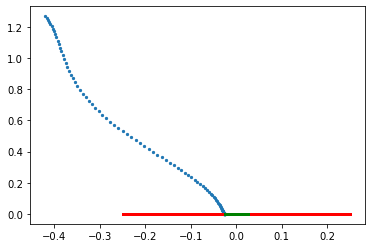

[67] loss: 0.000


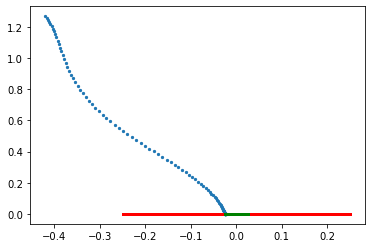

[68] loss: 0.000


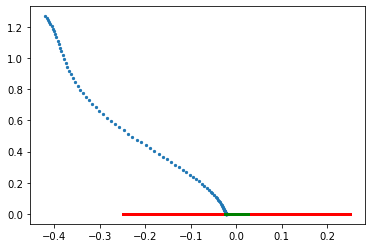

[69] loss: 0.000


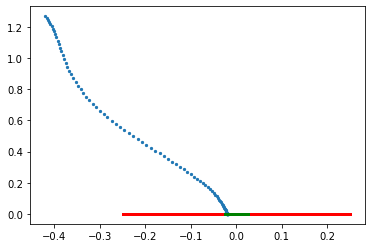

[70] loss: 0.000


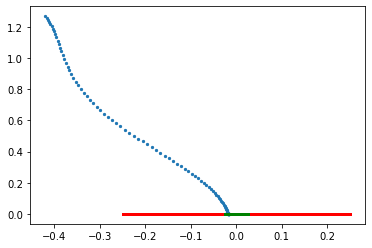

[71] loss: 0.000


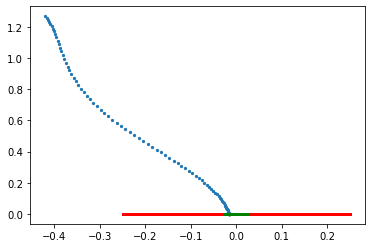

[72] loss: 0.000


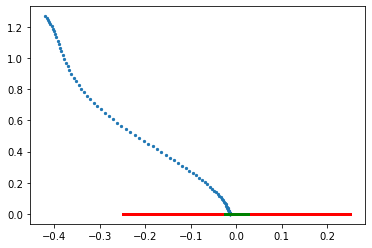

[73] loss: 0.000


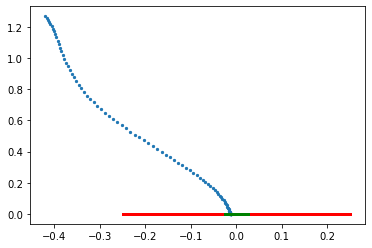

Landing Trajectory:


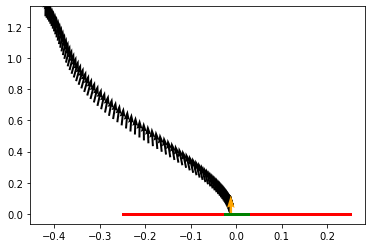

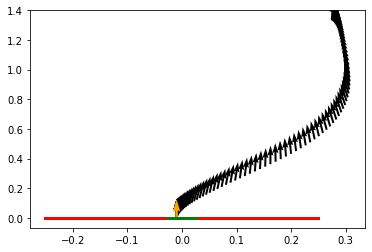

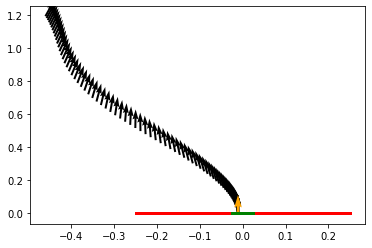

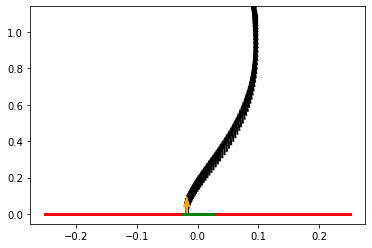

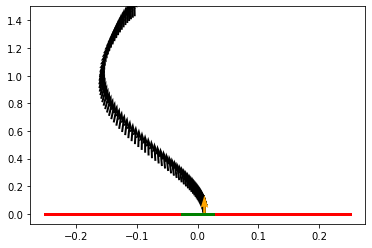

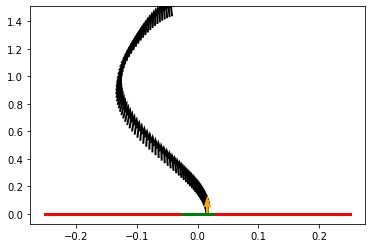

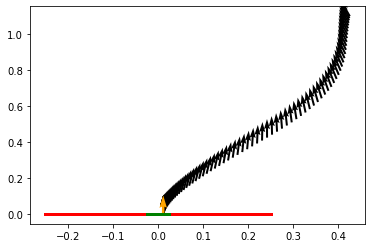

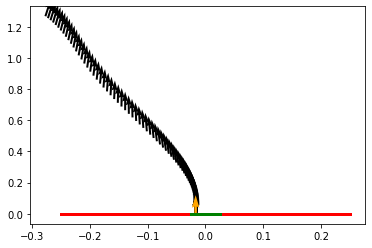

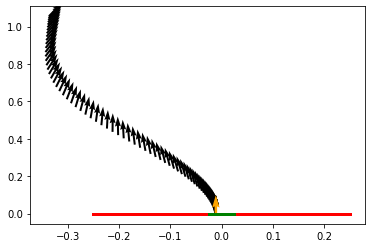

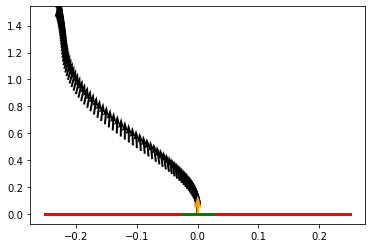

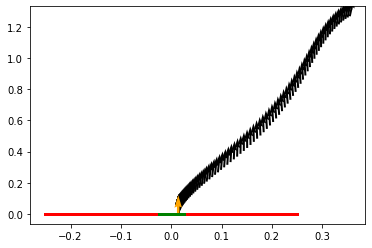

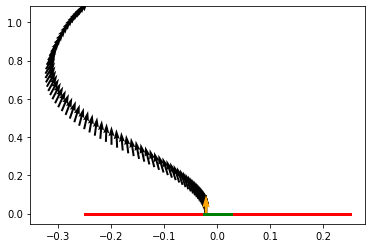

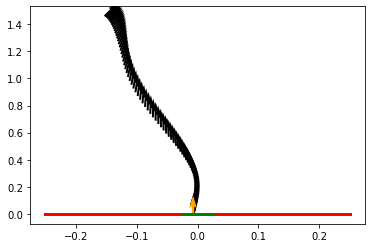

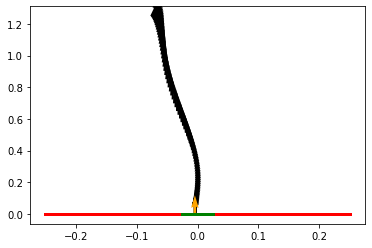

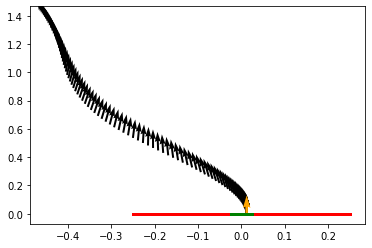

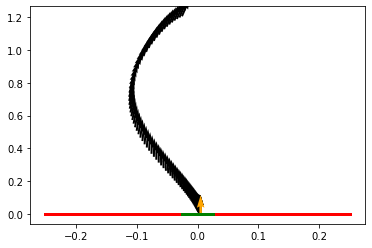

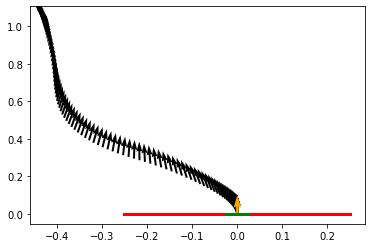

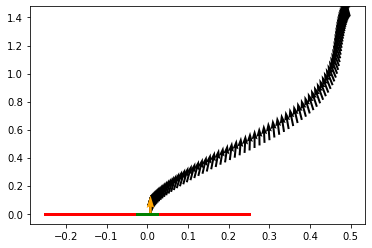

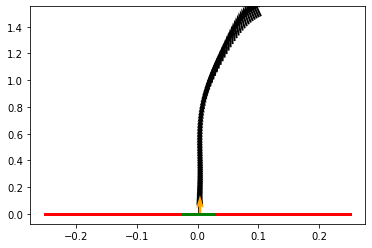

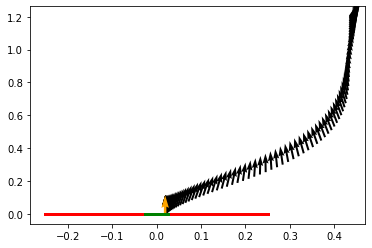

Convergence Plot:


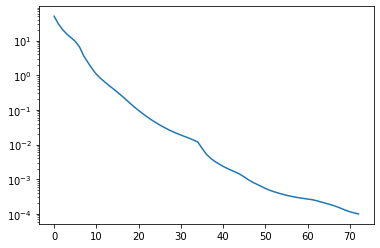

In [863]:
# Now it's time to run the code!

T = 100  # number of time steps
N = 20  # number of initial states
err = 0.0001 # acceptable_error
itr = 120 # max_iteration
dim_input = 6  # state space dimensions
dim_hidden1 = 12  # latent dimensions
dim_hidden2 = 4  # latent dimensions
dim_output = 2  # action space dimensions
d = Dynamics()  # define dynamics
c = Controller(dim_input, dim_hidden1, dim_hidden2, dim_output)  # define controller
s = Simulation(c, d, T, N)  # define simulation
o = Optimize(s)  # define optimizer
o.train(err,itr)  # solve the optimization problem
